# Basic end-to-end training of a LightGBM model
_To be added next:_ 
- An example of Bayesian Optimisation (inspired by the comment in [this kernel](https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/))- this is not expected to bring singificant improvement, but it is a fun technique to exercise

Features that are illustrated in this kernel:
- data reading with **memory footprint reduction**
- categorical feature encoding using **one-hot-encoding (OHE)**
-  internal **category weighting** by _**LightGBM**_ was tuned and no need of resampling is shown
- **gradient-boosted decision trees** using _**LightGBM**_ package
- **early stopping** in _**LightGBM**_ model training to avoid overtraining
- **learning rate decay** in _**LightGBM**_ model training to improve convergence to the minimum
- **hyperparameter optimisation** of the model using random search in cross validation
- submission preparation
This kernel inherited ideas and SW solutions from other public kernels and in such cases I will post direct references to the original product, that that you can get some additional insights from the source.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
plt.xkcd()

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
PATH = "../data/home-credit-default-risk/"
print(os.listdir(PATH))

# Any results you write to the current directory are saved as output.

['application_test.csv', 'bureau_balance.csv.zip', 'application_train.csv.zip', 'credit_card_balance.csv.zip', 'application_test.csv.zip', 'HomeCredit_columns_description.csv', 'POS_CASH_balance.csv', 'credit_card_balance.csv', 'installments_payments.csv', 'application_train.csv', 'installments_payments.csv.zip', 'bureau.csv', 'POS_CASH_balance.csv.zip', 'previous_application.csv', 'bureau.csv.zip', 'bureau_balance.csv', 'previous_application.csv.zip', 'sample_submission.csv.zip', 'sample_submission.csv']


## Read in the data reducing memory pattern for variables.
The implementation was copied over from [this kernel](https://www.kaggle.com/gemartin/load-data-reduce-memory-usage)

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [3]:
application_train = import_data(PATH+'application_train.csv')
application_test = import_data(PATH+'application_test.csv')

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 59.54 MB
Decreased by 79.2%
Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 9.40 MB
Decreased by 79.1%


In [20]:
# bureau_data = import_data(PATH + 'bureau.csv')
# bureau_balance_data = import_data(PATH + 'bureau_balance.csv')
previous_applications_data = import_data(PATH + 'previous_application.csv')

Memory usage of dataframe is 471.48 MB
Memory usage after optimization is: 130.62 MB
Decreased by 72.3%


Bureau data has good number of users covered

In [11]:
len(application_train['SK_ID_CURR'].unique())

307511

In [22]:
bureau_balance_data.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


The following 2 cells with cleaning criteria were inherited from [this kernel](https://www.kaggle.com/kingychiu/home-credit-eda-distributions-and-outliers)

In [4]:
application_train = application_train[application_train['AMT_INCOME_TOTAL'] != 1.170000e+08]
application_train = application_train[application_train['AMT_REQ_CREDIT_BUREAU_QRT'] != 261]
application_train = application_train[application_train['OBS_30_CNT_SOCIAL_CIRCLE'] < 300]

In [5]:
application_train['DAYS_EMPLOYED'] = (application_train['DAYS_EMPLOYED'].apply(lambda x: x if x != 365243 else np.nan))

## Additional numerical columns constructed from EXT_SOURCE_x

In [34]:
def feat_ext_source(df):
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    
    df2 = df[df['CODE_GENDER'] != 'XNA'].copy()
    del df
    df = df2

    x1 = df['EXT_SOURCE_1'].fillna(-1) + 1e-1
    x2 = df['EXT_SOURCE_2'].fillna(-1) + 1e-1
    x3 = df['EXT_SOURCE_3'].fillna(-1) + 1e-1
    
    df['EXT_SOURCE_1over2_NAminus1_Add0.1'] = x1/x2
    df['EXT_SOURCE_2over1_NAminus1_Add0.1'] = x2/x1
    df['EXT_SOURCE_1over3_NAminus1_Add0.1'] = x1/x3
    df['EXT_SOURCE_3over1_NAminus1_Add0.1'] = x3/x1
    df['EXT_SOURCE_2over3_NAminus1_Add0.1'] = x2/x3
    df['EXT_SOURCE_3over2_NAminus1_Add0.1'] = x3/x2
    
    df['EXT_SOURCE_na1_2'] = (application_train['EXT_SOURCE_1'].isnull()) * (application_train['EXT_SOURCE_2'].fillna(0))
    df['EXT_SOURCE_na1_3'] = (application_train['EXT_SOURCE_1'].isnull()) * (application_train['EXT_SOURCE_3'].fillna(0))
    df['EXT_SOURCE_na2_1'] = (application_train['EXT_SOURCE_2'].isnull()) * (application_train['EXT_SOURCE_1'].fillna(0))
    df['EXT_SOURCE_na2_3'] = (application_train['EXT_SOURCE_2'].isnull()) * (application_train['EXT_SOURCE_3'].fillna(0))
    df['EXT_SOURCE_na3_1'] = (application_train['EXT_SOURCE_3'].isnull()) * (application_train['EXT_SOURCE_1'].fillna(0))
    df['EXT_SOURCE_na3_2'] = (application_train['EXT_SOURCE_3'].isnull()) * (application_train['EXT_SOURCE_2'].fillna(0))
    
    return df

In [35]:
application_train = feat_ext_source(application_train)
application_test  = feat_ext_source(application_test)

## Categorical encoding
The function was taken from [this kernel](https://www.kaggle.com/sz8416/simple-intro-eda-baseline-model-with-gridsearch). It allows to do OneHotEncoding (OHE) keeping only those columns that are common to train and test samples. OHE is performed using `pd.get_dummies`, which allows to convert categorical features, while keeping numerical untouched

In [36]:
# use this if you want to convert categorical features to dummies(default)
def cat_to_dummy(train, test):
    train_d = pd.get_dummies(train, drop_first=False)
    test_d = pd.get_dummies(test, drop_first=False)
    # make sure that the number of features in train and test should be same
    for i in train_d.columns:
        if i not in test_d.columns:
            if i!='TARGET':
                train_d = train_d.drop(i, axis=1)
    for j in test_d.columns:
        if j not in train_d.columns:
            if j!='TARGET':
                test_d = test_d.drop(i, axis=1)
    print('Memory usage of train increases from {:.2f} to {:.2f} MB'.format(train.memory_usage().sum() / 1024**2, 
                                                                            train_d.memory_usage().sum() / 1024**2))
    print('Memory usage of test increases from {:.2f} to {:.2f} MB'.format(test.memory_usage().sum() / 1024**2, 
                                                                            test_d.memory_usage().sum() / 1024**2))
    return train_d, test_d

application_train_ohe, application_test_ohe = cat_to_dummy(application_train, application_test)

Memory usage of train increases from 86.88 to 122.24 MB
Memory usage of test increases from 12.00 to 17.62 MB


## Deal with category imbalance
Use a standard library (`imblearn`) to to random undersampling on the dominating category. Use if if you want to repeat the HP optimisation

In [37]:
# You can use the full sample and do sample weighting in lightgbm using `is_unbalance` OR `scale_pos_weight` argument
# But it makes the code to run 8x..10x slower, which is ok for the run with pre-optimised parametersm but is too slow for HP optimisation
X_rus, y_rus = (application_train_ohe.drop(['SK_ID_CURR', 'TARGET'], axis=1),
                application_train_ohe['TARGET'])

# Model fitting with HyperParameter optimisation
We will use LightGBM classifier - LightGBM allows to build very sophysticated models with a very short training time.
### Split the full sample into train/test (80/20)

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, test_size=0.20, random_state=314, stratify=y_rus)

### Prepare learning rate shrinkage

In [39]:
def learning_rate_010_decay_power_0995(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

### Use test subset for early stopping criterion 
This allows us to avoid overtraining and we do not need to optimise the number of trees

In [40]:
import lightgbm as lgb
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            'verbose': 100,
            'categorical_feature': 'auto'}

### Set up HyperParameter search
We use random search, which is more flexible and more efficient than a grid search

In [41]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [42]:
#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 100

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 1000 define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=1000)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

Run this cell, to do HP optimisation. To save time `opt_parameters` was directly hardcoded below.

In [43]:
#gs.fit(X_train, y_train, **fit_params)
#print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

# Derived optimal parameters
opt_parameters = {'colsample_bytree': 0.9234, 'min_child_samples': 399, 'min_child_weight': 0.1, 'num_leaves': 13, 'reg_alpha': 2, 'reg_lambda': 5, 'subsample': 0.855}

## Tune the weights of unbalanced classes
Following discussion in [this comment](https://www.kaggle.com/mlisovyi/modular-good-fun-with-ligthgbm/comments#337494), there was a small tuning of the disbalanced sample weight:


In [44]:
clf_sw = lgb.LGBMClassifier(**clf.get_params())
#set optimal parameters
clf_sw.set_params(**opt_parameters)

gs_sample_weight = GridSearchCV(estimator=clf_sw, 
                                param_grid={'scale_pos_weight':[8, 12]},
                                scoring='roc_auc',
                                cv=3,
                                refit=True,
                                verbose=True)

gs_sample_weight.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs_sample_weight.best_score_, gs_sample_weight.best_params_))

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.766742
[200]	valid's auc: 0.768582
Early stopping, best iteration is:
[199]	valid's auc: 0.76863
Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.765533
[200]	valid's auc: 0.768314
Early stopping, best iteration is:
[247]	valid's auc: 0.768891
Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.766865
[200]	valid's auc: 0.769007
Early stopping, best iteration is:
[259]	valid's auc: 0.76929
Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.765788
[200]	valid's auc: 0.767366
Early stopping, best iteration is:
[172]	valid's auc: 0.767426
Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.765881
[200]	valid's auc: 0.76753
Early stopping, best iteration is:
[228]	valid's auc: 0.767668
Training until validation scores don't 

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.4min finished


Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.768821
[200]	valid's auc: 0.771736
Early stopping, best iteration is:
[251]	valid's auc: 0.772628
Best score reached: 0.7630234131532047 with params: {'scale_pos_weight': 8} 


As an outcome, precision of the classifier does not depend much on the internal class weighting, but `weight=1` still turns out to give slightly better performance that weighted scenarios.

### Look at the performance of the top-5 parameter choices
(the list is inverted)

In [68]:
#print("Valid+-Std     Train  :   Parameters")
#for i in np.argsort(gs.cv_results_['mean_test_score'])[-5:]:
#    print('{1:.3f}+-{3:.3f}     {2:.3f}   :  {0}'.format(gs.cv_results_['params'][i], 
#                                    gs.cv_results_['mean_test_score'][i], 
#                                    gs.cv_results_['mean_train_score'][i],
#                                    gs.cv_results_['std_test_score'][i]))

In [45]:
print("Valid+-Std     Train  :   Parameters")
for i in np.argsort(gs_sample_weight.cv_results_['mean_test_score'])[-5:]:
    print('{1:.3f}+-{3:.3f}     {2:.3f}   :  {0}'.format(gs_sample_weight.cv_results_['params'][i], 
                                    gs_sample_weight.cv_results_['mean_test_score'][i], 
                                    gs_sample_weight.cv_results_['mean_train_score'][i],
                                    gs_sample_weight.cv_results_['std_test_score'][i]))

Valid+-Std     Train  :   Parameters
0.763+-0.003     0.804   :  {'scale_pos_weight': 12}
0.763+-0.003     0.808   :  {'scale_pos_weight': 8}


/Users/nitin/.local/share/virtualenvs/ownwork-7IQXCDiI/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


## Build the final model
We do training with the 0.8 subset of the dataset and 0.2 subset for early stopping. We use the tuned parameter values but a smaller learning rate to allow smoother convergence to the minimum

In [46]:
clf_final.get_params

<bound method LGBMModel.get_params of LGBMClassifier(boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.9234, learning_rate=0.005, max_depth=-1,
        metric='None', min_child_samples=399, min_child_weight=0.1,
        min_split_gain=0.0, n_estimators=2000, n_jobs=4,
        num_iterations=200, num_leaves=13, objective='binary',
        random_state=314, reg_alpha=2, reg_lambda=5, silent=True,
        subsample=0.855, subsample_for_bin=200000, subsample_freq=1)>

In [48]:
#Configure from the HP optimisation
#clf_final = lgb.LGBMClassifier(**gs.best_estimator_.get_params())

#Configure locally from hardcoded values
clf_final = lgb.LGBMClassifier(**clf.get_params())
#set optimal parameters
clf_final.set_params(**opt_parameters)

#force larger number of max trees and smaller learning rate
clf_final.set_params(n_estimators=2500, learning_rate=0.005, objective='binary', num_iterations=250)
clf_final.fit(X_train, y_train, **fit_params,
              callbacks=[lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_0995)])

/Users/nitin/.local/share/virtualenvs/ownwork-7IQXCDiI/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.764125
[200]	valid's auc: 0.769533
Did not meet early stopping. Best iteration is:
[250]	valid's auc: 0.770356


LGBMClassifier(boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.9234, learning_rate=0.005, max_depth=-1,
        metric='None', min_child_samples=399, min_child_weight=0.1,
        min_split_gain=0.0, n_estimators=2500, n_jobs=4,
        num_iterations=250, num_leaves=13, objective='binary',
        random_state=314, reg_alpha=2, reg_lambda=5, silent=True,
        subsample=0.855, subsample_for_bin=200000, subsample_freq=1)

### Plot feature importance

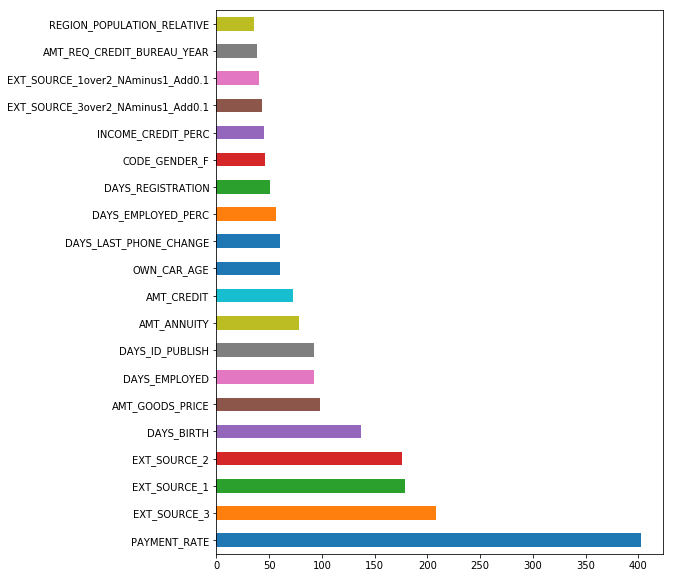

In [49]:
feat_imp = pd.Series(clf_final.feature_importances_, index=application_train_ohe.drop(['SK_ID_CURR', 'TARGET'], axis=1).columns)
feat_imp.nlargest(20).plot(kind='barh', figsize=(8,10))

# Predict on the submission test sample

In [31]:
probabilities = clf_final.predict_proba(application_test_ohe.drop(['SK_ID_CURR'], axis=1))
submission = pd.DataFrame({
    'SK_ID_CURR': application_test_ohe['SK_ID_CURR'],
    'TARGET':     [ row[1] for row in probabilities]
})
submission.to_csv("submission.csv", index=False)